### Transfer Learnig (전이 학습)

In [1]:
# cats_and_dogs classification model with InceptionV3
# train : 2000 images [cat(1000) + dog(1000)]  , size는 다름
# validation : 1000 images [cat(500) + dog(500)] , size는 다름

In [1]:
import tensorflow as tf
import urllib
import zipfile
from tensorflow.keras.preprocessing.image import ImageDataGenerator
from tensorflow.keras.optimizers import RMSprop

from tensorflow.keras import layers
from tensorflow.keras import Model

In [2]:
# Google InceptionV3 pretrained model 가중치 다운로드, Windows용
_INCEPTION_URL = "https://storage.googleapis.com/mledu-datasets/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5"
urllib.request.urlretrieve(_INCEPTION_URL, 'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5')

('tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5',
 <http.client.HTTPMessage at 0x1fb66643010>)

In [11]:
# 사전 훈련된 가중치 불러오기
from tensorflow.keras.applications.inception_v3 import InceptionV3

local_weight_file = r'tmp/inception_v3_weights_tf_dim_ordering_tf_kernels_notop.h5'

pre_trained_model = InceptionV3(input_shape=(150,150,3),
                                include_top = False,
                                weights = None)
pre_trained_model.load_weights(local_weight_file)

# 사전 훈련 계층의 가중치의 훈련 가능 여부를 설정 : False(학습안함)
for layer in pre_trained_model.layers:
    layer.trainable = False

# pre_trained_model.summary()

last_layer = pre_trained_model.get_layer('mixed7')
print("last shape: ", last_layer.output_shape) # (None, 7, 7, 768)
last_output = last_layer.output

last shape:  (None, 7, 7, 768)


In [16]:
# 모델 구성 / 컴파일
# Flatten layer
x = layers.Flatten()(last_output) # (None, 37632)
# Dense Layer : Hidden Layer
x = layers.Dense(1024,activation='relu')(x)
# Dropout Layer : 0.2
x = layers.Dropout(0.2)(x)
#Dense Layer : Final Output Layer, sigmoid
x = layers.Dense(1,activation='sigmoid')(x)

model = Model(pre_trained_model.input,x)
model.summary()

Model: "model_2"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_6 (InputLayer)           [(None, 150, 150, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d_470 (Conv2D)            (None, 74, 74, 32)   864         ['input_6[0][0]']                
                                                                                                  
 batch_normalization_470 (Batch  (None, 74, 74, 32)  96          ['conv2d_470[0][0]']             
 Normalization)                                                                                   
                                                                                            

In [18]:
model.compile(loss='binary_crossentropy',
              optimizer=RMSprop(learning_rate=0.001),
              metrics=['accuracy'])

### 이미지 증강

In [22]:
import os
train_cats_dir = os.path.join('tmp2/cats_and_dogs/cats_and_dogs_filtered/train/cats')
train_dogs_dir = os.path.join('tmp2/cats_and_dogs/cats_and_dogs_filtered/train/dogs')
validation_cats_dir = os.path.join('tmp2/cats_and_dogs/cats_and_dogs_filtered/validation/cats')
validation_dogs_dir = os.path.join('tmp2/cats_and_dogs/cats_and_dogs_filtered/validation/dogs')

train_cats_names = os.listdir(train_cats_dir)
train_dogs_names = os.listdir(train_dogs_dir)
validation_cats_names = os.listdir(validation_cats_dir)
validation_dogs_names = os.listdir(validation_dogs_dir)

In [23]:
train_dir = 'tmp2/cats_and_dogs/cats_and_dogs_filtered/train'
validation_dir = 'tmp2/cats_and_dogs/cats_and_dogs_filtered/validation'

In [24]:
from tensorflow.keras.preprocessing.image import ImageDataGenerator

train_datagen = ImageDataGenerator(rescale=1./255.,
                                   rotation_range=40,
                                   width_shift_range=0.2,
                                   height_shift_range=0.2,
                                   shear_range=0.2,
                                   zoom_range=0.2,
                                   horizontal_flip=True,                                   
                                  )
validation_datagen = ImageDataGenerator(rescale=1./255.)

train_generator = train_datagen.flow_from_directory(train_dir,                    
                                                    batch_size=20,
                                                    class_mode = 'binary',
                                                    target_size = (150,150))

validation_generator = validation_datagen.flow_from_directory(validation_dir,                                                              
                                                              batch_size=20,
                                                              class_mode = 'binary',
                                                              target_size = (150,150))

Found 2000 images belonging to 2 classes.
Found 1000 images belonging to 2 classes.


In [25]:
# 학습
# fit 호출시 1 epoch 마다 train 이미지 2000개 생성 
# fit 호출시 1 epoch 마다 validation 이미지 1000개 생성 
history = model.fit(train_generator, # X
          steps_per_epoch=100,  # 2000/20
          epochs=20,
          validation_data=validation_generator,
          validation_steps=50, # 1000/20
          verbose=1)

Epoch 1/20
100/100 [==============================] - 31s 296ms/step - loss: 1.2932 - accuracy: 0.8275 - val_loss: 0.1446 - val_accuracy: 0.9500
Epoch 2/20
100/100 [==============================] - 29s 290ms/step - loss: 0.4054 - accuracy: 0.8750 - val_loss: 0.1570 - val_accuracy: 0.9500
Epoch 3/20
100/100 [==============================] - 29s 292ms/step - loss: 0.2590 - accuracy: 0.9160 - val_loss: 0.1563 - val_accuracy: 0.9550
Epoch 4/20
100/100 [==============================] - 29s 291ms/step - loss: 0.2847 - accuracy: 0.9185 - val_loss: 0.1753 - val_accuracy: 0.9560
Epoch 5/20
100/100 [==============================] - 30s 295ms/step - loss: 0.2601 - accuracy: 0.9205 - val_loss: 0.1350 - val_accuracy: 0.9590
Epoch 6/20
100/100 [==============================] - 29s 292ms/step - loss: 0.2857 - accuracy: 0.9145 - val_loss: 0.1555 - val_accuracy: 0.9540
Epoch 7/20
100/100 [==============================] - 29s 289ms/step - loss: 0.2162 - accuracy: 0.9345 - val_loss: 0.1333 - val_ac

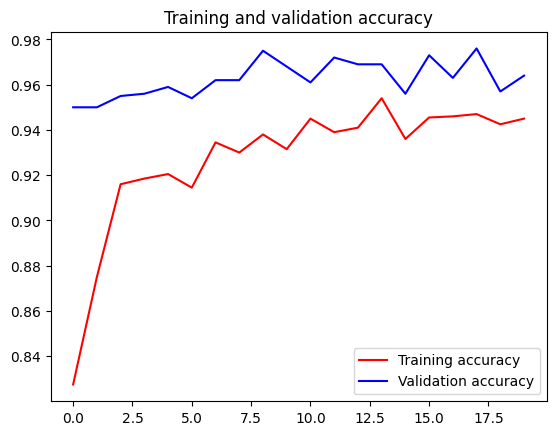

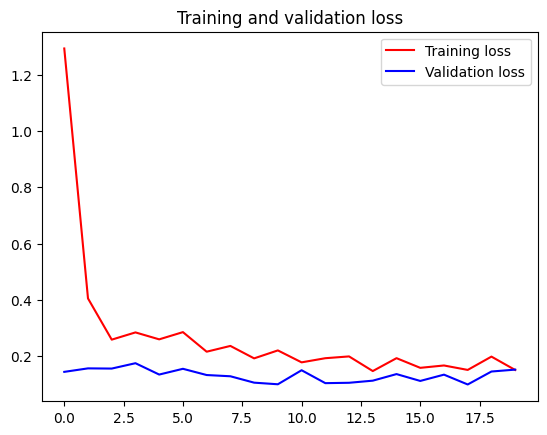

In [26]:
# 학습 결과 시각화 (옵션)
import matplotlib.pyplot as plt

acc = history.history['accuracy']
val_acc = history.history['val_accuracy']
loss = history.history['loss']
val_loss = history.history['val_loss']

epochs = range(len(acc))

plt.plot(epochs, acc, 'r', label='Training accuracy')
plt.plot(epochs, val_acc, 'b', label='Validation accuracy')
plt.title('Training and validation accuracy')
plt.legend()
plt.figure()

plt.plot(epochs, loss, 'r', label='Training loss')
plt.plot(epochs, val_loss, 'b', label='Validation loss')
plt.title('Training and validation loss')
plt.legend()

plt.show()